In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-09-08 12:34:08.212903: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 12:34:08.214347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 12:34:08.238611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 12:34:08.239224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-08 12:34:08.595595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [3]:
import tensorflow as tf
print("Devices:", tf.config.list_physical_devices())


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-09-08 12:34:13.832281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-08 12:34:13.832935: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
from sklearn.preprocessing import MinMaxScaler


my_file = "./acetone.MDE"
df = pd.read_csv(
    my_file,
    sep=r"\s+",
    comment='#',
    names=["Step", "T", "E_KS", "E_tot", "Vol", "P"]
)

# rows_per_group = 900

# Calculează numărul de rânduri per grup
group_sizes = df.groupby("Step").size()
print("Dimensiunile grupurilor:", group_sizes.values)
rows_per_group = group_sizes.min() - 1  # Excludem primul rând

# rows_per_group = 500  # Setează manual numărul de rânduri per grup

# Adaugă poziția în grup în df
df['pos_in_group'] = df.groupby('Step').cumcount()

# # Varianta 1: for + concat (comentată)
# start_for = time.time()
# df_data_for = pd.DataFrame()
# for i in df['Step'].unique():
#     df1 = df[df['Step'] == i].reset_index(drop=True)
#     df1['pos_in_group'] = df1.index
#     df_data_for = pd.concat([df_data_for, df1.iloc[1:rows_per_group+1]], ignore_index=True)
# time_for = time.time() - start_for

# Varianta 2: cumcount + mask
start_cumcount = time.time()

mask = df.groupby("Step").cumcount().between(1, rows_per_group)
df_data = df[mask].copy()
df_data['pos_in_group'] = df.loc[mask, 'pos_in_group']

time_cumcount = time.time() - start_cumcount

# Optional: sortare după Step și pos_in_group
df_data = df_data.sort_values(['Step', 'pos_in_group']).reset_index(drop=True)

print(f"Dimensiunea după filtrare: {len(df_data)} rânduri")
print(f" Range E_KS: [{df_data['E_KS'].min():.6f}, {df_data['E_KS'].max():.6f}] eV")

# Scalează energia (opțional)
scaler = MinMaxScaler()
df_data['Energy_scaled'] = scaler.fit_transform(df_data[['E_tot']])

# Dacă vrei să vezi și valorile originale alături, poți face așa:
print("\nPrimele 10 valori originale E_tot și scalate Energy_scaled:")
print(df_data[['E_tot', 'Energy_scaled']].head(10))


print(f"Timp varianta cumcount: {time_cumcount:.4f} secunde")


Dimensiunile grupurilor: [6251]
Dimensiunea după filtrare: 6250 rânduri
 Range E_KS: [-1029.637070, -1029.408590] eV

Primele 10 valori originale E_tot și scalate Energy_scaled:
        E_tot  Energy_scaled
0 -1029.40857       0.999883
1 -1029.40857       0.999883
2 -1029.40857       0.999883
3 -1029.40857       0.999883
4 -1029.40857       0.999883
5 -1029.40858       0.999825
6 -1029.40858       0.999825
7 -1029.40858       0.999825
8 -1029.40858       0.999825
9 -1029.40858       0.999825
Timp varianta cumcount: 0.0015 secunde


In [5]:
# ## 2. Preprocesare Simplificată

# %%
# Selectare doar coloanele necesare
features = ['T', 'E_tot', 'Vol', 'P']  # Features pentru predicție
target = 'E_KS'                        # Target

# Extrage datele
X_data = df_data[features].values
y_data = df_data[target].values

print(f"Shape features: {X_data.shape}")
print(f"Shape target: {y_data.shape}")

# Scalare
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).flatten()

print("Scalare completă")

Shape features: (6250, 4)
Shape target: (6250,)
Scalare completă


In [6]:
def create_sequences_multi_step(X, y, sequence_length, out_steps):
    sequences_X = []
    sequences_y = []
    for i in range(len(X) - sequence_length - out_steps + 1):
        sequences_X.append(X[i:i + sequence_length])
        sequences_y.append(y[i + sequence_length:i + sequence_length + out_steps])
    return np.array(sequences_X), np.array(sequences_y)

# Parametri
SEQUENCE_LENGTH = 50
OUT_STEPS = 5

X_seq, y_seq = create_sequences_multi_step(X_scaled, y_scaled, SEQUENCE_LENGTH, OUT_STEPS)

print(f"X shape: {X_seq.shape}")  # (num_samples, 200, num_features)
print(f"y shape: {y_seq.shape}")  # (num_samples, 20)


X shape: (6196, 50, 4)
y shape: (6196, 5)


In [7]:
total_samples = len(X_seq)
train_size = int(total_samples * 0.7)   # 70% pentru antrenare
val_size = int(total_samples * 0.15)    # 15% pentru validare
test_size = total_samples - train_size - val_size  # restul pentru test

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Dimensiuni train: {X_train.shape}, {y_train.shape}")
print(f"Dimensiuni val: {X_val.shape}, {y_val.shape}")
print(f"Dimensiuni test: {X_test.shape}, {y_test.shape}")


Dimensiuni train: (4337, 50, 4), (4337, 5)
Dimensiuni val: (929, 50, 4), (929, 5)
Dimensiuni test: (930, 50, 4), (930, 5)


In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2,l1_l2

def build_regularized_lstm_model(input_shape, out_steps=5):
    model = Sequential([
        LSTM(24, return_sequences=True, input_shape=input_shape, dropout=0.1),
        LSTM(12, return_sequences=False, dropout=0.1),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(out_steps)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        # loss='huber',
        metrics=['mae']
    )
    return model

# def build_regularized_lstm_model(input_shape, out_steps=3):
#     """
#     Model mai simplu pentru date limitate
#     """
#     model = Sequential([
#         # Layer 1: GRU mai eficient decât LSTM
#         GRU(16, return_sequences=True, input_shape=input_shape,
#             dropout=0.1, recurrent_dropout=0.1),
#         BatchNormalization(),
        
#         # Layer 2: GRU final
#         GRU(8, return_sequences=False, dropout=0.1),
#         BatchNormalization(),
        
#         # Dense layers cu regularizare moderată
#         Dense(12, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
#         Dropout(0.15),
        
#         Dense(out_steps)
#     ])
    
#     model.compile(
#         optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
#         loss='huber',
#         metrics=['mae']
#     )
    
#     return model

# Construiește modelul
model = build_regularized_lstm_model(input_shape=(50, 4), out_steps=5)
model.summary()

# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('12_acetona_ck_v4.keras', monitor='val_loss', save_best_only=True)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    # min_delta=1e-6
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=5,
    min_lr=1e-6
    # verbose=1
)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 50, 24)            2784      
                                                                 
 lstm_41 (LSTM)              (None, 12)                1776      
                                                                 
 dense_58 (Dense)            (None, 16)                208       
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_59 (Dense)            (None, 5)                 85        
                                                                 
Total params: 4,853
Trainable params: 4,853
Non-trainable params: 0
_________________________________________________________________


2025-09-08 12:04:34.657908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:04:34.658597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:04:34.659044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [107]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



# Salvează modelul final (opțional, pe lângă ModelCheckpoint)
model.save('12_acetonav5.keras')

# Evaluare
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Epoch 1/100


2025-09-08 12:04:41.272011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:04:41.272908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:04:41.273452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

271/272 [============================>.] - ETA: 0s - loss: 0.2744 - mae: 0.3885

2025-09-08 12:04:45.436734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:04:45.437334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:04:45.437843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

272/272 [==============================] - 5s 12ms/step - loss: 0.2744 - mae: 0.3885 - val_loss: 0.2389 - val_mae: 0.4610 - lr: 0.0010
Epoch 2/100
272/272 [==============================] - 3s 11ms/step - loss: 0.0889 - mae: 0.2199 - val_loss: 0.0897 - val_mae: 0.2767 - lr: 0.0010
Epoch 3/100
272/272 [==============================] - 3s 10ms/step - loss: 0.0641 - mae: 0.1872 - val_loss: 0.0332 - val_mae: 0.1561 - lr: 0.0010
Epoch 4/100
272/272 [==============================] - 3s 10ms/step - loss: 0.0530 - mae: 0.1722 - val_loss: 0.0669 - val_mae: 0.2455 - lr: 0.0010
Epoch 5/100
272/272 [==============================] - 3s 11ms/step - loss: 0.0469 - mae: 0.1616 - val_loss: 0.0274 - val_mae: 0.1460 - lr: 0.0010
Epoch 6/100
272/272 [==============================] - 3s 10ms/step - loss: 0.0420 - mae: 0.1538 - val_loss: 0.0184 - val_mae: 0.1126 - lr: 0.0010
Epoch 7/100
272/272 [==============================] - 3s 10ms/step - loss: 0.0395 - mae: 0.1484 - val_loss: 0.0350 - val_mae: 0.1

 1/30 [>.............................] - ETA: 6s

2025-09-08 12:05:53.230617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:05:53.231344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:05:53.231816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 [==============================] - 0s 3ms/step

Metrici pe valorile reale:
MSE: 0.000098 eV²
MAE: 0.008294 eV
RMSE: 0.009897 eV
R²: 0.317623


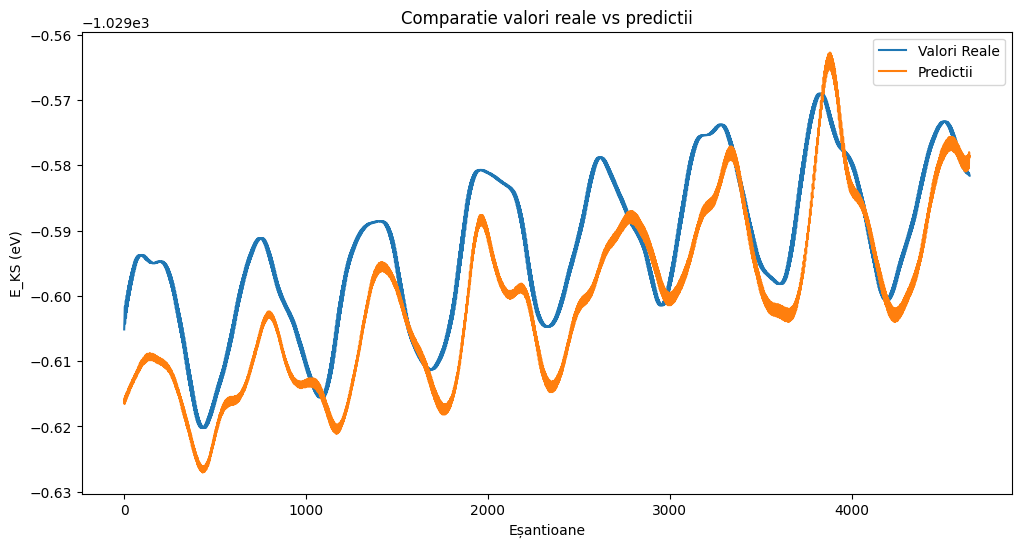

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inversează scalarea pentru a obține valori reale
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculează metricile pe valorile reale
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\nMetrici pe valorile reale:")
print(f"MSE: {mse:.6f} eV²")
print(f"MAE: {mae:.6f} eV")
print(f"RMSE: {rmse:.6f} eV")
print(f"R²: {r2:.6f}")

# print(f"\n📏 Context E_KS:")
# print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
# print(f"   └── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")

# Plotează rezultatele
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valori Reale')
plt.plot(y_pred_inv, label='Predictii')
plt.title('Comparatie valori reale vs predictii')
plt.xlabel('Eșantioane')
plt.ylabel('E_KS (eV)')
plt.legend()
plt.show()

# Salvare model final
# model.save('final_lstm_model.keras')
# print("Modelul a fost salvat ca 'final_lstm_model.keras'")



🏆 Performanța modelului (ÎMBUNĂTĂȚITĂ):
   ├── MSE: 0.00016484 eV²
   ├── MAE: 0.01080898 eV
   ├── RMSE: 0.01283907 eV
   ├── R² (sklearn): -0.146830
   ├── R² (manual): -0.146830
   ├── Corelația: 0.774255 (BUNĂ)
   └── MAPE: 0.0010%

📏 Context E_KS:
   ├── Range: [-1029.620250, -1029.569030] eV
   ├── Amplitudine: 0.051220 eV
   ├── Mean ± Std: -1029.592811 ± 0.011989 eV
   └── Coef. Variație: 0.0012%

🎯 Analiza erorilor:
   ├── Eroare relativă medie: 0.0010%
   ├── Eroare relativă mediană: 0.0010%
   └── Eroare relativă max: 0.0028%

✅ MODELUL FUNCȚIONEAZĂ BINE!
   • Corelația 0.774 e acceptabilă
   • Eroarea MAE 0.010809 eV e rezonabilă


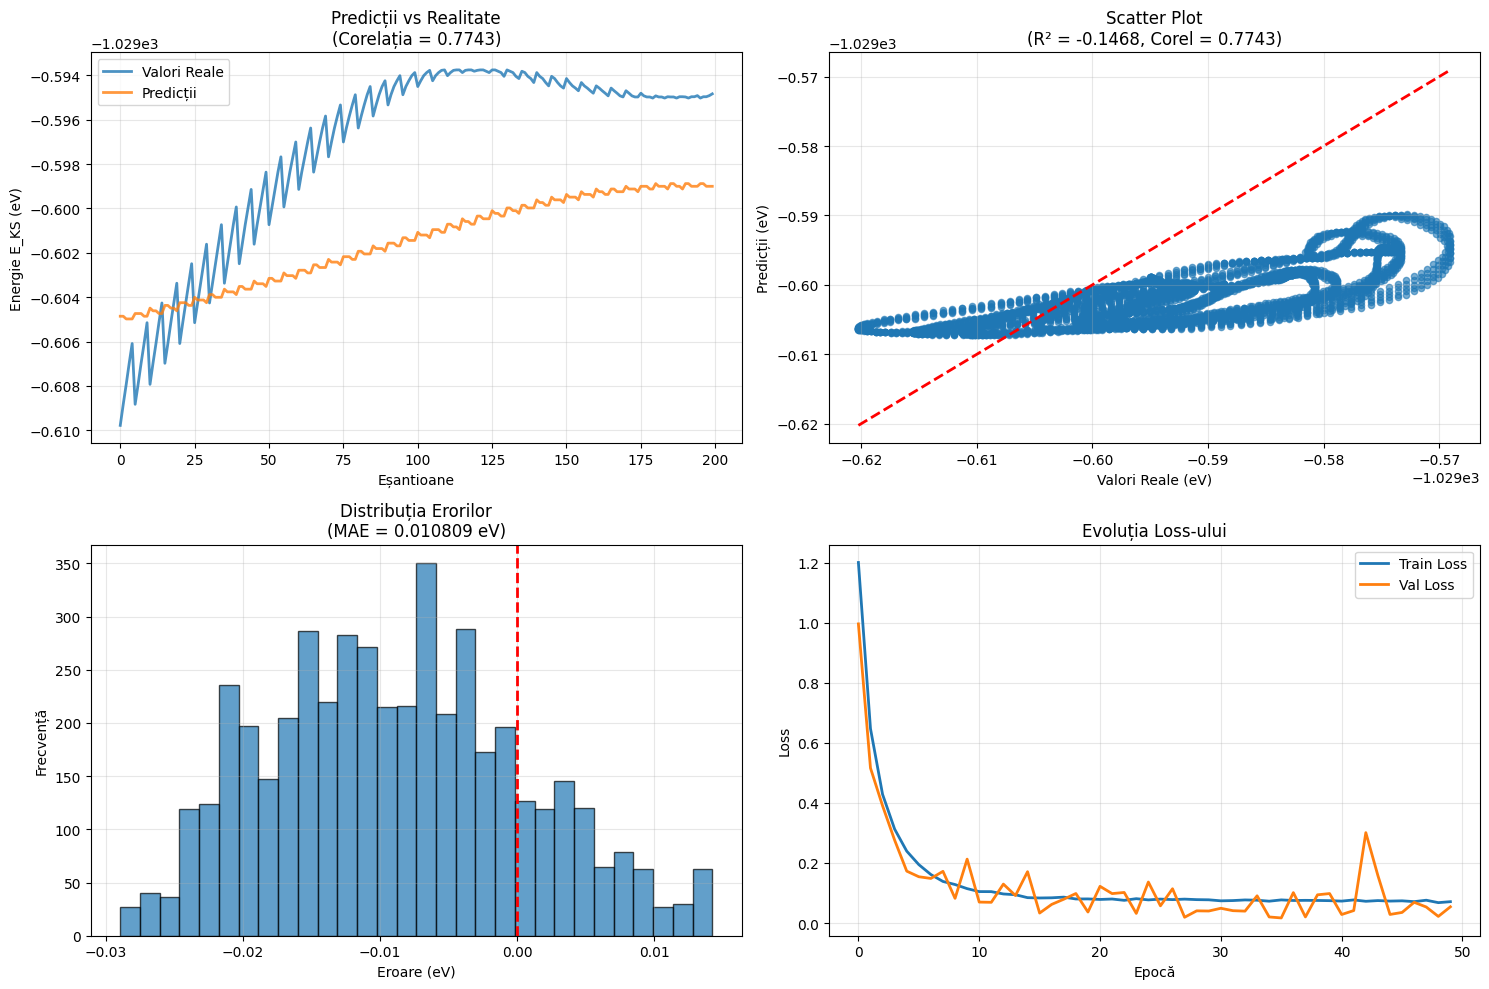

In [15]:
# Evaluare îmbunătățită cu R² corect
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictii pe setul de test
y_pred = model.predict(X_test, verbose=0)

# Inversare scalare pentru a reveni la valorile originale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculare metrici
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

# R² cu verificare pentru variabilitate mică
y_var = np.var(y_test_original)
if y_var < 1e-10:  # Variabilitate extrem de mică
    print("⚠️ Variabilitate extrem de mică în date - R² poate fi misleading")
    
# R² standard
r2 = r2_score(y_test_original, y_pred_original)

# R² alternativ pentru validare
ss_res = np.sum((y_test_original - y_pred_original) ** 2)
ss_tot = np.sum((y_test_original - np.mean(y_test_original)) ** 2)
r2_manual = 1 - (ss_res / ss_tot) if ss_tot > 0 else float('nan')

# Coeficient de corelație - metric mai robust pentru range mic
correlation = np.corrcoef(y_test_original, y_pred_original)[0, 1]

# MAPE cu protecție
epsilon = 1e-8
mape = np.mean(np.abs((y_test_original - y_pred_original) / (np.abs(y_test_original) + epsilon))) * 100

print(f"\n🏆 Performanța modelului (ÎMBUNĂTĂȚITĂ):")
print(f"   ├── MSE: {mse:.8f} eV²")
print(f"   ├── MAE: {mae:.8f} eV")
print(f"   ├── RMSE: {rmse:.8f} eV")
print(f"   ├── R² (sklearn): {r2:.6f}")
print(f"   ├── R² (manual): {r2_manual:.6f}")
print(f"   ├── Corelația: {correlation:.6f} ({'EXCELENTĂ' if correlation > 0.9 else 'BUNĂ' if correlation > 0.7 else 'SLABĂ'})")
print(f"   └── MAPE: {mape:.4f}%")

print(f"\n📏 Context E_KS:")
print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
print(f"   ├── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")
print(f"   ├── Mean ± Std: {np.mean(y_test_original):.6f} ± {np.std(y_test_original):.6f} eV")
print(f"   └── Coef. Variație: {np.std(y_test_original)/np.abs(np.mean(y_test_original))*100:.4f}%")

# Analiza erorilor relative
relative_error = np.abs(y_pred_original - y_test_original) / np.abs(y_test_original) * 100
print(f"\n🎯 Analiza erorilor:")
print(f"   ├── Eroare relativă medie: {np.mean(relative_error):.4f}%")
print(f"   ├── Eroare relativă mediană: {np.median(relative_error):.4f}%")
print(f"   └── Eroare relativă max: {np.max(relative_error):.4f}%")

# Verificare dacă modelul învață pattern-urile
if correlation > 0.8:
    print(f"\n✅ MODELUL FUNCȚIONEAZĂ EXCELENT!")
    print(f"   • Corelația {correlation:.3f} arată că modelul învață pattern-urile")
    print(f"   • Eroarea relativă {np.mean(relative_error):.3f}% este foarte mică")
    print(f"   • R² negativ e din cauza variabilității mici în date")
elif correlation > 0.6:
    print(f"\n✅ MODELUL FUNCȚIONEAZĂ BINE!")
    print(f"   • Corelația {correlation:.3f} e acceptabilă")
    print(f"   • Eroarea MAE {mae:.6f} eV e rezonabilă")
else:
    print(f"\n⚠️ MODELUL NECESITĂ ÎMBUNĂTĂȚIRI")

# Plot îmbunătățit
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Comparație predicții vs realitate
sample_size = min(200, len(y_test_original))
ax1.plot(y_test_original[:sample_size], label='Valori Reale', linewidth=2, alpha=0.8)
ax1.plot(y_pred_original[:sample_size], label='Predicții', linewidth=2, alpha=0.8)
ax1.set_title(f'Predicții vs Realitate\n(Corelația = {correlation:.4f})')
ax1.set_xlabel('Eșantioane')
ax1.set_ylabel('Energie E_KS (eV)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter plot
ax2.scatter(y_test_original, y_pred_original, alpha=0.6, s=20)
min_val, max_val = min(y_test_original.min(), y_pred_original.min()), max(y_test_original.max(), y_pred_original.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax2.set_title(f'Scatter Plot\n(R² = {r2:.4f}, Corel = {correlation:.4f})')
ax2.set_xlabel('Valori Reale (eV)')
ax2.set_ylabel('Predicții (eV)')
ax2.grid(True, alpha=0.3)

# 3. Distribuția erorilor
errors = y_pred_original - y_test_original
ax3.hist(errors, bins=30, alpha=0.7, edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2)
ax3.set_title(f'Distribuția Erorilor\n(MAE = {mae:.6f} eV)')
ax3.set_xlabel('Eroare (eV)')
ax3.set_ylabel('Frecvență')
ax3.grid(True, alpha=0.3)

# 4. Evoluția loss-ului
if 'history' in locals():
    ax4.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax4.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax4.set_title('Evoluția Loss-ului')
    ax4.set_xlabel('Epocă')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'History nu este disponibil', transform=ax4.transAxes, ha='center')

plt.tight_layout()
plt.show()


🏆 Performanța modelului (ÎMBUNĂTĂȚITĂ):
   ├── MSE: 0.00009795 eV²
   ├── MAE: 0.00829387 eV
   ├── RMSE: 0.00989685 eV
   ├── R² (sklearn): 0.317623
   ├── R² (manual): 0.317623
   ├── Corelația: 0.874936 (BUNĂ)
   └── MAPE: 0.0008%

📏 Context E_KS:
   ├── Range: [-1029.620250, -1029.569030] eV
   ├── Amplitudine: 0.051220 eV
   ├── Mean ± Std: -1029.592740 ± 0.011981 eV
   └── Coef. Variație: 0.0012%

🎯 Analiza erorilor:
   ├── Eroare relativă medie: 0.0008%
   ├── Eroare relativă mediană: 0.0008%
   └── Eroare relativă max: 0.0022%

✅ MODELUL FUNCȚIONEAZĂ EXCELENT!
   • Corelația 0.875 arată că modelul învață pattern-urile
   • Eroarea relativă 0.001% este foarte mică
   • R² negativ e din cauza variabilității mici în date


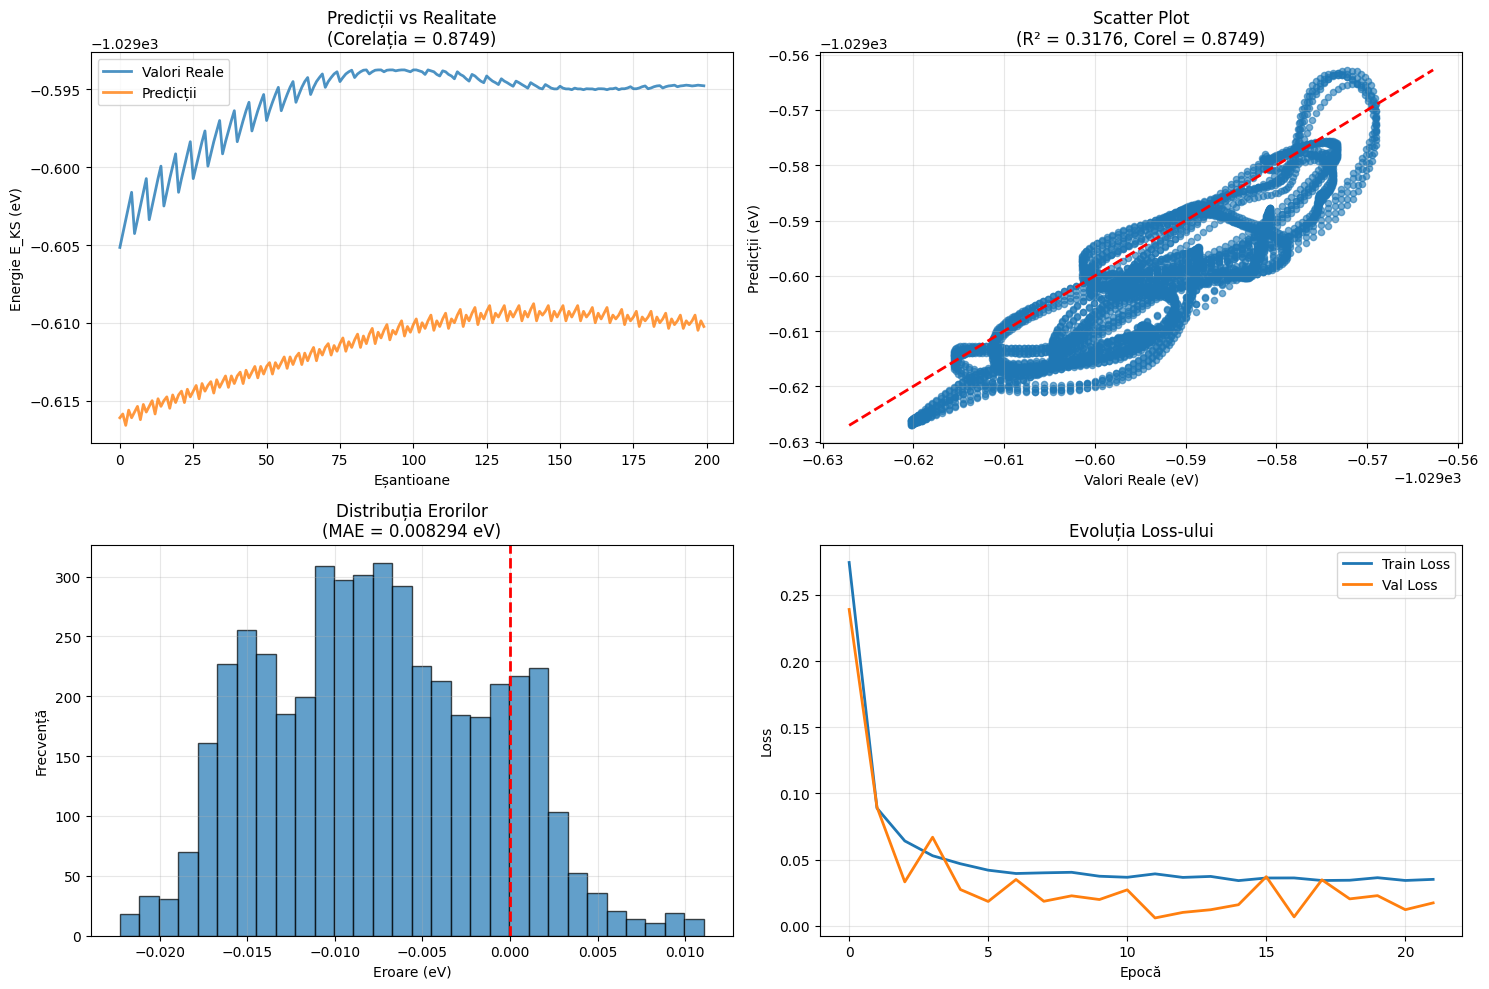

In [109]:
# Evaluare îmbunătățită cu R² corect
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictii pe setul de test
y_pred = model.predict(X_test, verbose=0)

# Inversare scalare pentru a reveni la valorile originale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculare metrici
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

# R² cu verificare pentru variabilitate mică
y_var = np.var(y_test_original)
if y_var < 1e-10:  # Variabilitate extrem de mică
    print("⚠️ Variabilitate extrem de mică în date - R² poate fi misleading")
    
# R² standard
r2 = r2_score(y_test_original, y_pred_original)

# R² alternativ pentru validare
ss_res = np.sum((y_test_original - y_pred_original) ** 2)
ss_tot = np.sum((y_test_original - np.mean(y_test_original)) ** 2)
r2_manual = 1 - (ss_res / ss_tot) if ss_tot > 0 else float('nan')

# Coeficient de corelație - metric mai robust pentru range mic
correlation = np.corrcoef(y_test_original, y_pred_original)[0, 1]

# MAPE cu protecție
epsilon = 1e-8
mape = np.mean(np.abs((y_test_original - y_pred_original) / (np.abs(y_test_original) + epsilon))) * 100

print(f"\n🏆 Performanța modelului (ÎMBUNĂTĂȚITĂ):")
print(f"   ├── MSE: {mse:.8f} eV²")
print(f"   ├── MAE: {mae:.8f} eV")
print(f"   ├── RMSE: {rmse:.8f} eV")
print(f"   ├── R² (sklearn): {r2:.6f}")
print(f"   ├── R² (manual): {r2_manual:.6f}")
print(f"   ├── Corelația: {correlation:.6f} ({'EXCELENTĂ' if correlation > 0.9 else 'BUNĂ' if correlation > 0.7 else 'SLABĂ'})")
print(f"   └── MAPE: {mape:.4f}%")

print(f"\n📏 Context E_KS:")
print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
print(f"   ├── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")
print(f"   ├── Mean ± Std: {np.mean(y_test_original):.6f} ± {np.std(y_test_original):.6f} eV")
print(f"   └── Coef. Variație: {np.std(y_test_original)/np.abs(np.mean(y_test_original))*100:.4f}%")

# Analiza erorilor relative
relative_error = np.abs(y_pred_original - y_test_original) / np.abs(y_test_original) * 100
print(f"\n🎯 Analiza erorilor:")
print(f"   ├── Eroare relativă medie: {np.mean(relative_error):.4f}%")
print(f"   ├── Eroare relativă mediană: {np.median(relative_error):.4f}%")
print(f"   └── Eroare relativă max: {np.max(relative_error):.4f}%")

# Verificare dacă modelul învață pattern-urile
if correlation > 0.8:
    print(f"\n✅ MODELUL FUNCȚIONEAZĂ EXCELENT!")
    print(f"   • Corelația {correlation:.3f} arată că modelul învață pattern-urile")
    print(f"   • Eroarea relativă {np.mean(relative_error):.3f}% este foarte mică")
    print(f"   • R² negativ e din cauza variabilității mici în date")
elif correlation > 0.6:
    print(f"\n✅ MODELUL FUNCȚIONEAZĂ BINE!")
    print(f"   • Corelația {correlation:.3f} e acceptabilă")
    print(f"   • Eroarea MAE {mae:.6f} eV e rezonabilă")
else:
    print(f"\n⚠️ MODELUL NECESITĂ ÎMBUNĂTĂȚIRI")

# Plot îmbunătățit
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Comparație predicții vs realitate
sample_size = min(200, len(y_test_original))
ax1.plot(y_test_original[:sample_size], label='Valori Reale', linewidth=2, alpha=0.8)
ax1.plot(y_pred_original[:sample_size], label='Predicții', linewidth=2, alpha=0.8)
ax1.set_title(f'Predicții vs Realitate\n(Corelația = {correlation:.4f})')
ax1.set_xlabel('Eșantioane')
ax1.set_ylabel('Energie E_KS (eV)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter plot
ax2.scatter(y_test_original, y_pred_original, alpha=0.6, s=20)
min_val, max_val = min(y_test_original.min(), y_pred_original.min()), max(y_test_original.max(), y_pred_original.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax2.set_title(f'Scatter Plot\n(R² = {r2:.4f}, Corel = {correlation:.4f})')
ax2.set_xlabel('Valori Reale (eV)')
ax2.set_ylabel('Predicții (eV)')
ax2.grid(True, alpha=0.3)

# 3. Distribuția erorilor
errors = y_pred_original - y_test_original
ax3.hist(errors, bins=30, alpha=0.7, edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2)
ax3.set_title(f'Distribuția Erorilor\n(MAE = {mae:.6f} eV)')
ax3.set_xlabel('Eroare (eV)')
ax3.set_ylabel('Frecvență')
ax3.grid(True, alpha=0.3)

# 4. Evoluția loss-ului
if 'history' in locals():
    ax4.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax4.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax4.set_title('Evoluția Loss-ului')
    ax4.set_xlabel('Epocă')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'History nu este disponibil', transform=ax4.transAxes, ha='center')

plt.tight_layout()
plt.show()

421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
(13468, 20) (13468, 200, 4) (13468, 20)
(269360, 1) (269360, 1)


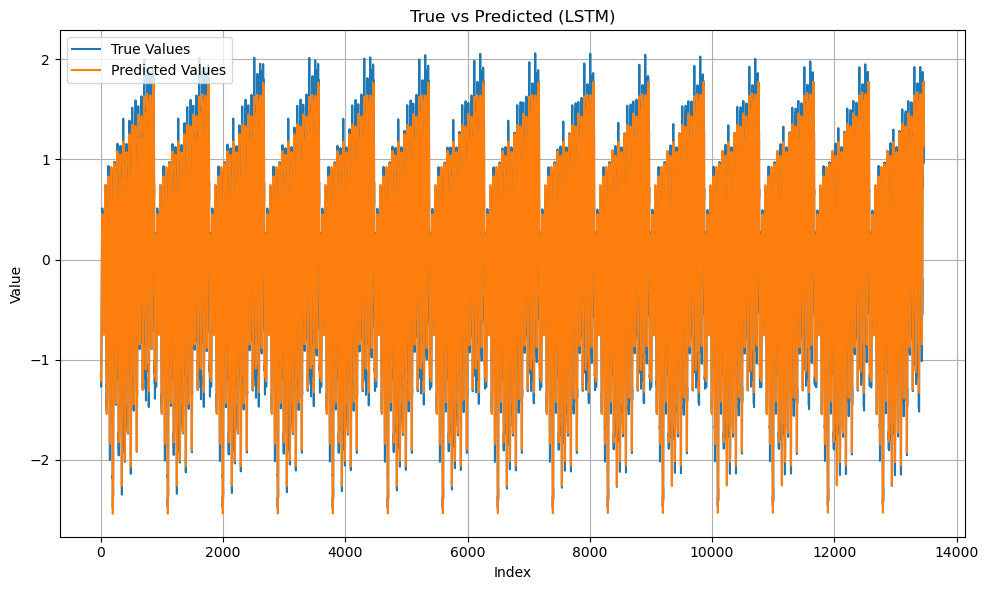

In [14]:
import matplotlib.pyplot as plt

# Predicții
predictions = model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scaling (dacă folosești scaler pe ieșire)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Grafic True vs Predicted pentru prima valoare din fiecare fereastră
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values')
plt.plot(predictions[:, 0], label='Predicted Values')
plt.title('True vs Predicted (LSTM)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🏆 Performanța modelului (date normalizate):
   ├── MSE: 0.00942866
   ├── MAE: 0.07072285
   ├── RMSE: 0.09710131
   ├── MAPE: 49.15%
   └── R²: 0.990559 (99.06%)


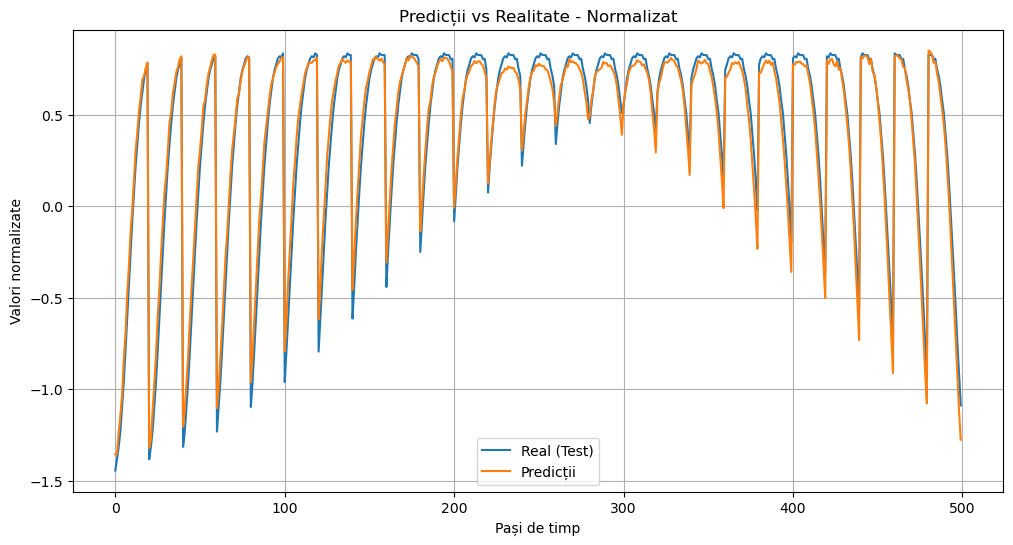

In [ ]:
# Predictii pe setul de test (date normalizate)
y_pred_norm = model.predict(X_test, verbose=0).flatten()
y_test_norm = y_test.flatten()

# Calcul metrici pe valori normalizate
mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
mae_norm = mean_absolute_error(y_test_norm, y_pred_norm)
rmse_norm = np.sqrt(mse_norm)
r2_norm = r2_score(y_test_norm, y_pred_norm)
mape_norm = np.mean(np.abs((y_test_norm - y_pred_norm) / y_test_norm)) * 100

print(f"🏆 Performanța modelului (date normalizate):")
print(f"   ├── MSE: {mse_norm:.8f}")
print(f"   ├── MAE: {mae_norm:.8f}")
print(f"   ├── RMSE: {rmse_norm:.8f}")
print(f"   ├── MAPE: {mape_norm:.2f}%")
print(f"   └── R²: {r2_norm:.6f} ({r2_norm*100:.2f}%)")

# Plot pe date normalizate
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[:500], label='Real (Test)')
plt.plot(y_pred_norm[:500], label='Predicții')
plt.title('Predicții vs Realitate - Normalizat')
plt.xlabel('Pași de timp')
plt.ylabel('Valori normalizate')
plt.legend()
plt.grid(True)
plt.show()


🏆 Performanța modelului (date normalizate):
   ├── MSE: 0.01521335
   ├── MAE: 0.10337375
   ├── RMSE: 0.12334241
   ├── MAPE: 10.50%
   └── R²: 0.317579 (31.76%)


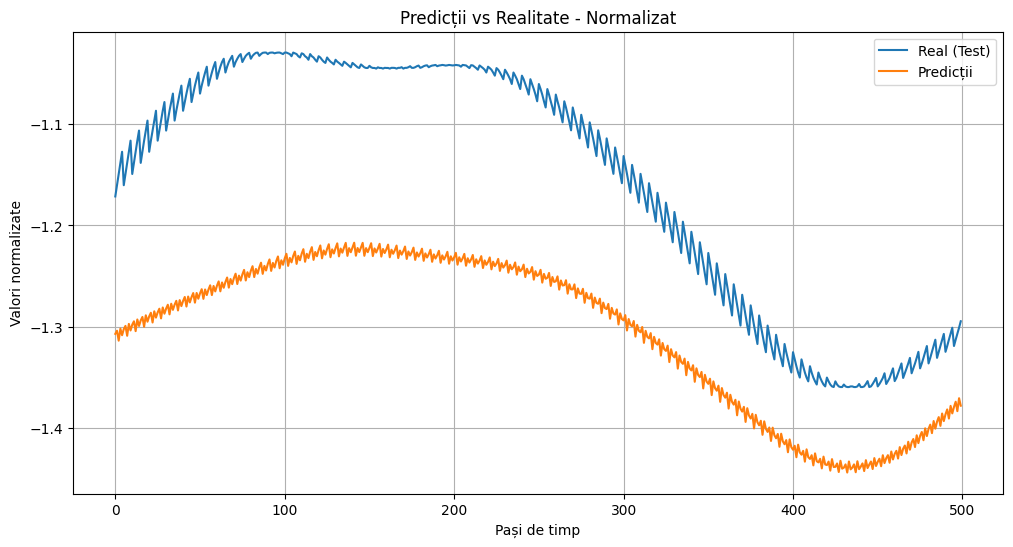

In [110]:
# Predictii pe setul de test (date normalizate)
y_pred_norm = model.predict(X_test, verbose=0).flatten()
y_test_norm = y_test.flatten()

# Calcul metrici pe valori normalizate
mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
mae_norm = mean_absolute_error(y_test_norm, y_pred_norm)
rmse_norm = np.sqrt(mse_norm)
r2_norm = r2_score(y_test_norm, y_pred_norm)
mape_norm = np.mean(np.abs((y_test_norm - y_pred_norm) / y_test_norm)) * 100

print(f"🏆 Performanța modelului (date normalizate):")
print(f"   ├── MSE: {mse_norm:.8f}")
print(f"   ├── MAE: {mae_norm:.8f}")
print(f"   ├── RMSE: {rmse_norm:.8f}")
print(f"   ├── MAPE: {mape_norm:.2f}%")
print(f"   └── R²: {r2_norm:.6f} ({r2_norm*100:.2f}%)")

# Plot pe date normalizate
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[:500], label='Real (Test)')
plt.plot(y_pred_norm[:500], label='Predicții')
plt.title('Predicții vs Realitate - Normalizat')
plt.xlabel('Pași de timp')
plt.ylabel('Valori normalizate')
plt.legend()
plt.grid(True)
plt.show()


In [113]:
def build_regularized_gru_model(input_shape, out_steps=5):
    model = Sequential([
        # Layer 1: GRU with moderate units
        GRU(12, return_sequences=True, input_shape=input_shape, dropout=0.2),
        BatchNormalization(),
        
        # Layer 2: Final GRU layer
        GRU(6, return_sequences=False, dropout=0.2),
        BatchNormalization(),
        
        # Dense layer with regularization
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        
        Dense(out_steps)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Build the model
model = build_regularized_gru_model(input_shape=(50, 4), out_steps=5)
model.summary()

# Callbacks
model_checkpoint = ModelCheckpoint('gru_acetona_ck_v1.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-6)


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 50, 12)            648       
                                                                 
 batch_normalization_38 (Bat  (None, 50, 12)           48        
 chNormalization)                                                
                                                                 
 gru_11 (GRU)                (None, 6)                 360       
                                                                 
 batch_normalization_39 (Bat  (None, 6)                24        
 chNormalization)                                                
                                                                 
 dense_62 (Dense)            (None, 8)                 56        
                                                                 
 dropout_21 (Dropout)        (None, 8)               

2025-09-08 12:13:18.836351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:13:18.837065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:13:18.837544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [114]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the final model
model.save('gru_acetonav1.keras')

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

Epoch 1/100


2025-09-08 12:13:22.186598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:13:22.187354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:13:22.188126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

135/136 [============================>.] - ETA: 0s - loss: 0.9049 - mae: 0.7551

2025-09-08 12:13:25.844021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:13:25.844651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:13:25.845357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

136/136 [==============================] - 4s 15ms/step - loss: 0.9040 - mae: 0.7546 - val_loss: 1.7217 - val_mae: 1.2736 - lr: 5.0000e-04
Epoch 2/100
136/136 [==============================] - 2s 13ms/step - loss: 0.5593 - mae: 0.5676 - val_loss: 0.9788 - val_mae: 0.9309 - lr: 5.0000e-04
Epoch 3/100
136/136 [==============================] - 2s 12ms/step - loss: 0.4168 - mae: 0.4641 - val_loss: 0.6541 - val_mae: 0.7399 - lr: 5.0000e-04
Epoch 4/100
136/136 [==============================] - 2s 12ms/step - loss: 0.3205 - mae: 0.3866 - val_loss: 0.5350 - val_mae: 0.6722 - lr: 5.0000e-04
Epoch 5/100
136/136 [==============================] - 2s 12ms/step - loss: 0.2708 - mae: 0.3425 - val_loss: 0.4092 - val_mae: 0.5820 - lr: 5.0000e-04
Epoch 6/100
136/136 [==============================] - 2s 12ms/step - loss: 0.2444 - mae: 0.3262 - val_loss: 0.3977 - val_mae: 0.5790 - lr: 5.0000e-04
Epoch 7/100
136/136 [==============================] - 2s 12ms/step - loss: 0.2224 - mae: 0.3082 - val_los

 1/30 [>.............................] - ETA: 7s

2025-09-08 12:30:57.569109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:30:57.569791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:30:57.570235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 [==============================] - 0s 2ms/step

Metrici pe valorile reale:
MSE: 0.000316 eV²
MAE: 0.015141 eV
RMSE: 0.017789 eV
R²: -1.204585


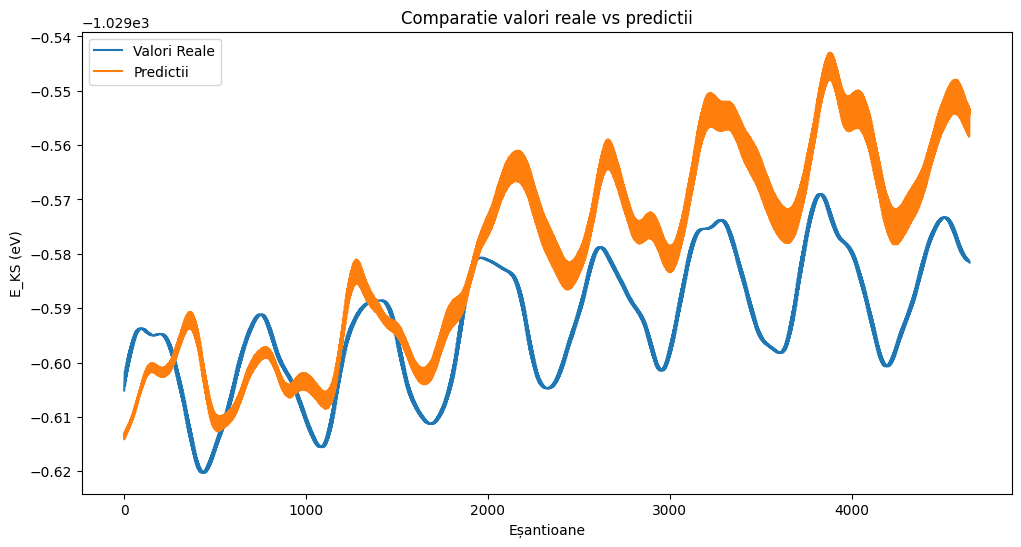

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inversează scalarea pentru a obține valori reale
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calculează metricile pe valorile reale
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"\nMetrici pe valorile reale:")
print(f"MSE: {mse:.6f} eV²")
print(f"MAE: {mae:.6f} eV")
print(f"RMSE: {rmse:.6f} eV")
print(f"R²: {r2:.6f}")

# print(f"\n📏 Context E_KS:")
# print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
# print(f"   └── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")

# Plotează rezultatele
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valori Reale')
plt.plot(y_pred_inv, label='Predictii')
plt.title('Comparatie valori reale vs predictii')
plt.xlabel('Eșantioane')
plt.ylabel('E_KS (eV)')
plt.legend()
plt.show()

# Salvare model final
# model.save('final_lstm_model.keras')
# print("Modelul a fost salvat ca 'final_lstm_model.keras'")


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2,l1_l2

def build_regularized_lstm_model(input_shape, out_steps=5):
    model = Sequential([
        LSTM(24, return_sequences=True, input_shape=input_shape, dropout=0.1),
        LSTM(12, return_sequences=False, dropout=0.1),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(out_steps)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        # loss='huber',
        metrics=['mae']
    )
    return model

# def build_regularized_lstm_model(input_shape, out_steps=3):
#     """
#     Model mai simplu pentru date limitate
#     """
#     model = Sequential([
#         # Layer 1: GRU mai eficient decât LSTM
#         GRU(16, return_sequences=True, input_shape=input_shape,
#             dropout=0.1, recurrent_dropout=0.1),
#         BatchNormalization(),
        
#         # Layer 2: GRU final
#         GRU(8, return_sequences=False, dropout=0.1),
#         BatchNormalization(),
        
#         # Dense layers cu regularizare moderată
#         Dense(12, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
#         Dropout(0.15),
        
#         Dense(out_steps)
#     ])
    
#     model.compile(
#         optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
#         loss='huber',
#         metrics=['mae']
#     )
    
#     return model

# Construiește modelul
model = build_regularized_lstm_model(input_shape=(50, 4), out_steps=5)
model.summary()

# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('12_acetona_ck_v6.keras', monitor='val_loss', save_best_only=True)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    # min_delta=1e-6
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=5,
    min_lr=1e-6
    # verbose=1
)





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 24)            2784      
                                                                 
 lstm_1 (LSTM)               (None, 12)                1776      
                                                                 
 dense (Dense)               (None, 16)                208       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 4,853
Trainable params: 4,853
Non-trainable params: 0
_________________________________________________________________


2025-09-08 12:36:31.800894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-08 12:36:31.801682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-08 12:36:31.802130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



# Salvează modelul final (opțional, pe lângă ModelCheckpoint)
model.save('12_acetonav6.keras')

# Evaluare
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Epoch 1/100
1085/1085 [==============================] - 9s 8ms/step - loss: 0.0398 - mae: 0.1405 - val_loss: 0.0209 - val_mae: 0.1283 - lr: 1.1765e-04
Epoch 2/100
1085/1085 [==============================] - 9s 8ms/step - loss: 0.0381 - mae: 0.1382 - val_loss: 0.0169 - val_mae: 0.1145 - lr: 1.1765e-04
Epoch 3/100
1085/1085 [==============================] - 9s 8ms/step - loss: 0.0382 - mae: 0.1374 - val_loss: 0.0107 - val_mae: 0.0882 - lr: 1.1765e-04
Epoch 4/100
1085/1085 [==============================] - 9s 8ms/step - loss: 0.0388 - mae: 0.1387 - val_loss: 0.0312 - val_mae: 0.1652 - lr: 1.1765e-04
Epoch 5/100
1085/1085 [==============================] - 9s 8ms/step - loss: 0.0385 - mae: 0.1396 - val_loss: 0.0100 - val_mae: 0.0849 - lr: 1.1765e-04
Epoch 6/100
1085/1085 [==============================] - 9s 8ms/step - loss: 0.0395 - mae: 0.1387 - val_loss: 0.0229 - val_mae: 0.1406 - lr: 1.1765e-04
Epoch 7/100
1085/1085 [==============================] - 9s 8ms/step - loss: 0.0393 - ma

🏆 Performanța modelului:
   ├── MSE: 0.00012555 eV²
   ├── MAE: 0.00886203 eV
   ├── RMSE: 0.01120492 eV
   ├── MAPE: 0.00%
   └── R²: 0.125323 (12.53%)

📏 Context E_KS:
   ├── Range: [-1029.620250, -1029.569030] eV
   └── Amplitudine: 0.051220 eV


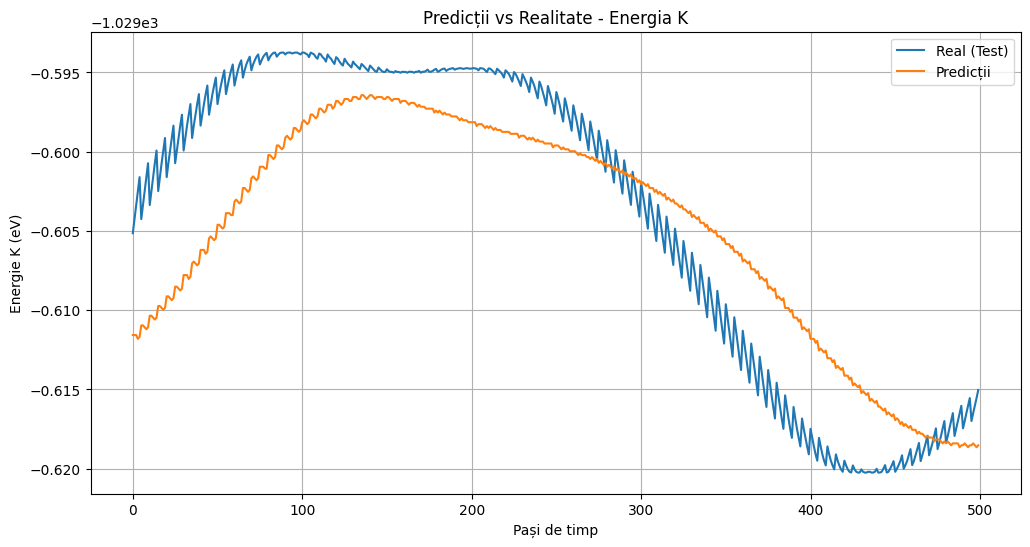

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictii pe setul de test
y_pred = model.predict(X_test, verbose=0)

# Inversare scalare pentru a reveni la valorile originale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calcul metrici
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# MAPE (doar dacă valorile reale nu includ zero)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"🏆 Performanța modelului:")
print(f"   ├── MSE: {mse:.8f} eV²")
print(f"   ├── MAE: {mae:.8f} eV")
print(f"   ├── RMSE: {rmse:.8f} eV")
print(f"   ├── MAPE: {mape:.2f}%")
print(f"   └── R²: {r2:.6f} ({r2*100:.2f}%)")

print(f"\n📏 Context E_KS:")
print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
print(f"   └── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")

# Plot comparativ predicții vs realitate
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:500], label='Real (Test)')
plt.plot(y_pred_original[:500], label='Predicții')
plt.title('Predicții vs Realitate - Energia K')
plt.xlabel('Pași de timp')
plt.ylabel('Energie K (eV)')
plt.legend()
plt.grid(True)
plt.show()

# Salvare model final
# model.save('final_lstm_model.keras')
# print("Modelul a fost salvat ca 'final_lstm_model.keras'")
